### Classificação de textos para análise de sentimentos

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 26-06-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

In [1]:
!which pip

/Users/leonardofiedler/Desenvolvimento/deep-learning/.venv/bin/pip


In [35]:
from torchtext import datasets
from string import punctuation
import pandas as pd

In [4]:
train_iter, test_iter = datasets.IMDB()

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:18<00:00, 4.62MB/s]


In [27]:
df_train = pd.DataFrame(train_iter, columns=['target','value'])

In [30]:
df_test = pd.DataFrame(test_iter, columns=['target','value'])
df_test.head()

,target,value
0,neg,"This cheap, grainy-filmed Italian flick is abo..."
1,neg,I just finished watching this movie and am dis...
2,neg,"Ben, (Rupert Grint), is a deeply unhappy adole..."
3,neg,Every movie I have PPV'd because Leonard Malti...
4,neg,Low budget horror movie. If you don't raise yo...


<AxesSubplot:>

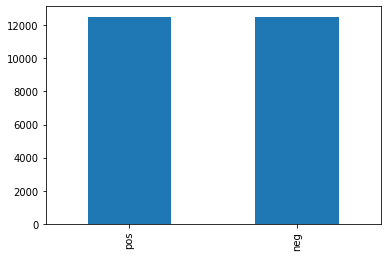

In [29]:
df_train.target.value_counts().plot.bar()

<AxesSubplot:>

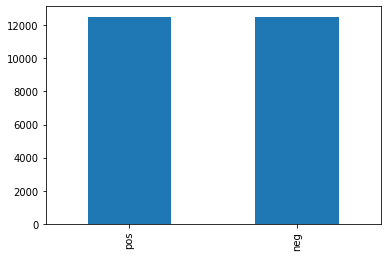

In [31]:
df_test.target.value_counts().plot.bar()

In [34]:
def preprocess_data(x):
    return x.lower()

df_train = df_train.assign(value = df_train.value.apply(lambda x: preprocess_data(x)))
df_test  = df_test.assign(value  = df_test.value.apply(lambda x: preprocess_data(x)))

df_train.head(), df_test.head()

(  target                                              value
 0    neg  my interest in dorothy stratten caused me to p...
 1    neg  i have this film out of the library right now ...
 2    neg  i think i will make a movie next weekend. oh w...
 3    neg  pros: nothing<br /><br />cons: everything<br /...
 4    neg  if the crew behind "zombie chronicles" ever re...,
   target                                              value
 0    neg  this cheap, grainy-filmed italian flick is abo...
 1    neg  i just finished watching this movie and am dis...
 2    neg  ben, (rupert grint), is a deeply unhappy adole...
 3    neg  every movie i have ppv'd because leonard malti...
 4    neg  low budget horror movie. if you don't raise yo...)